# Imports

In [92]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

# for plots
from datetime import datetime

# registering converters for plotting datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [15]:
# HDX Imports
from hdx.utilities.easy_logging import setup_logging
from hdx.hdx_configuration import Configuration
Configuration.create(hdx_site='prod', hdx_read_only=True,user_agent='WBG')
from hdx.data.dataset import Dataset
import os
import shutil

# Functions

In [17]:
def download_from_hdx():
    url, path = Dataset.get_resources(Dataset.read_from_hdx('movement-range-maps'))[1].download('data/')
    print('Resource URL %s downloaded to %s' % (url, path))
    return url,path


In [38]:
# Reading in the data manually now now but can automate with the download from HDX
def read_facebook_data(filepath='data/movement-range-data-2020-11-29/movement-range-2020-11-29.txt'):
    data = pd.read_csv(filepath,sep='\t')
    data['ds'] = pd.to_datetime(data['ds'])
    return data

In [23]:
def find_affected(boundaries,extent):
    return boundaries[boundaries.centroid.within(extent.geometry.squeeze())]

In [21]:
gadm_vnm = gpd.read_file('data/boundaries/vietnam/gadm36_VNM_shp/gadm36_VNM_2.shp')
gadm_phl = gpd.read_file('data/boundaries/philippines/gadm36_PHL_shp/gadm36_PHL_2.shp')

# Downloading and Reading data

In [44]:
data = read_facebook_data()

/Users/mahamfaisalkhan/anaconda3/envs/wbg/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [18]:
url, path = download_from_hdx()

Resource URL https://data.humdata.org/dataset/c3429f0e-651b-4788-bb2f-4adbf222c90e/resource/18094d52-1670-4e59-9577-c265074c921f/download/movement-range-data-2020-11-29.zip downloaded to data/movement-range-data-2020-11-29.zip.TSV


In [24]:
vnm_extent = gpd.read_file('data/disaster_extents/vietnam_flooding/vnm_extent.shp')
vnm_affected = find_affected(gadm_vnm,vnm_extent)

In [42]:
phl_extent = gpd.read_file('data/disaster_extents/philippines_flooding/phl_extent.shp')
phl_affected = find_affected(gadm_phl,phl_extent)

# Plotting disaster event

In [69]:
color = 'lightgrey'
alpha = 0.1
fontsize=9

## Vietnam

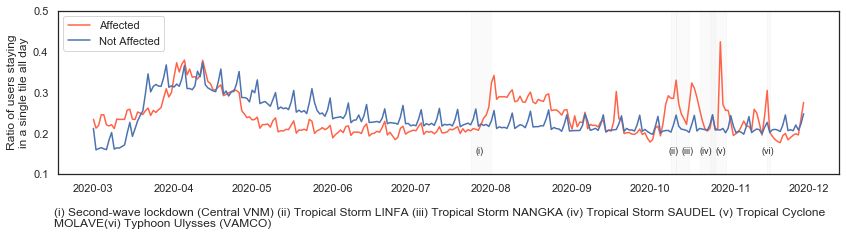

In [107]:
fig, ax = plt.subplots(figsize=(14,3))

sns.lineplot(data=data[data['polygon_id'].isin(vnm_affected['GID_2'].unique())].groupby('ds').mean().reset_index(),x='ds',y='all_day_ratio_single_tile_users',color='Tomato',ax=ax)
sns.lineplot(data=data[~data['polygon_id'].isin(vnm_affected['GID_2'].unique())].groupby('ds').mean().reset_index(),x='ds',y='all_day_ratio_single_tile_users',ax=ax)
plt.axvspan(datetime(2020,10,9),datetime(2020,10,11),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,10,11),datetime(2020,10,16),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,10,20),datetime(2020,10,26),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,10,24),datetime(2020,10,30),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,7,24),datetime(2020,8,1),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,11,15),datetime(2020,11,16),color=color,zorder=-10,alpha=alpha)
plt.text(datetime(2020,7,26),.15,'(i)',fontsize=fontsize) # Second lockdown
plt.text(datetime(2020,10,8),.15,'(ii)',fontsize=fontsize) #
plt.text(datetime(2020,10,13),.15,'(iii)',fontsize=fontsize) #
plt.text(datetime(2020,10,20),.15,'(iv)',fontsize=fontsize) #
plt.text(datetime(2020,10,26),.15,'(v)',fontsize=fontsize) # Molave
plt.text(datetime(2020,11,13),.15,'(vi)',fontsize=fontsize) # Ulysses
plt.text(datetime(2020,2,15),-0.03,'(i) Second-wave lockdown (Central VNM) (ii) Tropical Storm LINFA (iii) Tropical Storm NANGKA (iv) Tropical Storm SAUDEL (v) Tropical Cyclone\nMOLAVE(vi) Typhoon Ulysses (VAMCO)',ha='left')

plt.legend(['Affected','Not Affected'])
plt.xlabel('')
plt.ylabel('Ratio of users staying\nin a single tile all day')
plt.ylim([0.1,0.5])
plt.show()

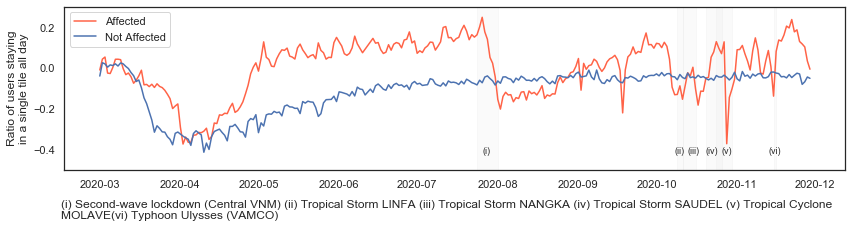

In [106]:
fig, ax = plt.subplots(figsize=(14,3))

sns.lineplot(data=data[data['polygon_id'].isin(vnm_affected['GID_2'].unique())].groupby('ds').mean().reset_index(),x='ds',y='all_day_bing_tiles_visited_relative_change',color='Tomato',ax=ax)
sns.lineplot(data=data[~data['polygon_id'].isin(vnm_affected['GID_2'].unique())].groupby('ds').mean().reset_index(),x='ds',y='all_day_bing_tiles_visited_relative_change',ax=ax)
plt.axvspan(datetime(2020,10,9),datetime(2020,10,11),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,10,11),datetime(2020,10,16),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,10,20),datetime(2020,10,26),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,10,24),datetime(2020,10,30),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,7,24),datetime(2020,8,1),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,11,15),datetime(2020,11,16),color=color,zorder=-10,alpha=alpha)
plt.text(datetime(2020,7,26),-.42,'(i)',fontsize=fontsize)
plt.text(datetime(2020,10,8),-.42,'(ii)',fontsize=fontsize)
plt.text(datetime(2020,10,13),-.42,'(iii)',fontsize=fontsize)
plt.text(datetime(2020,10,20),-.42,'(iv)',fontsize=fontsize)
plt.text(datetime(2020,10,26),-.42,'(v)',fontsize=fontsize)
plt.text(datetime(2020,11,13),-.42,'(vi)',fontsize=fontsize)
plt.legend(['Affected','Not Affected'])
plt.xlabel('')
plt.ylabel('Ratio of users staying\nin a single tile all day')
plt.ylim([-0.5,0.3])
plt.text(datetime(2020,2,15),-0.74,'(i) Second-wave lockdown (Central VNM) (ii) Tropical Storm LINFA (iii) Tropical Storm NANGKA (iv) Tropical Storm SAUDEL (v) Tropical Cyclone\nMOLAVE(vi) Typhoon Ulysses (VAMCO)',ha='left')
plt.show()


## Philippines

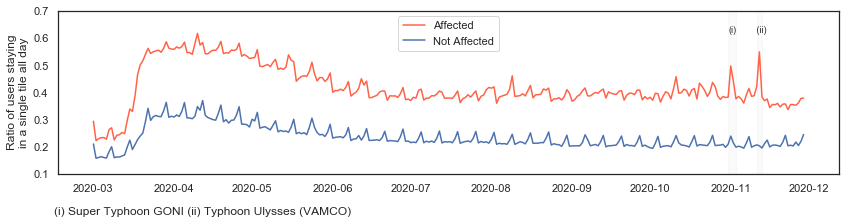

In [120]:
fig, ax = plt.subplots(figsize=(14,3))

sns.lineplot(data=data[data['polygon_id'].isin(phl_affected['GID_2'].unique())].groupby('ds').mean().reset_index(),x='ds',y='all_day_ratio_single_tile_users',color='Tomato',ax=ax)
sns.lineplot(data=data[~data['polygon_id'].isin(phl_affected['GID_2'].unique())].groupby('ds').mean().reset_index(),x='ds',y='all_day_ratio_single_tile_users',ax=ax)
plt.axvspan(datetime(2020,10,31),datetime(2020,11,3),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,11,11),datetime(2020,11,13),color=color,zorder=-10,alpha=alpha)
plt.text(datetime(2020,10,31),0.62,'(i)',fontsize=fontsize)
plt.text(datetime(2020,11,10),0.62,' (ii)',fontsize=fontsize)
plt.legend(['Affected','Not Affected'])
plt.xlabel('')
plt.ylabel('Ratio of users staying\nin a single tile all day')
plt.ylim([0.1,0.7])
plt.text(datetime(2020,2,15),-0.05,'(i) Super Typhoon GONI (ii) Typhoon Ulysses (VAMCO)',ha='left')
plt.show()

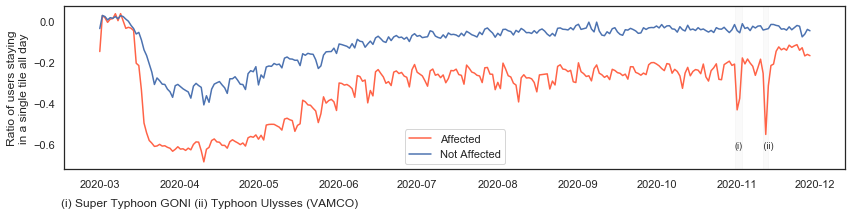

In [122]:
fig, ax = plt.subplots(figsize=(14,3))

sns.lineplot(data=data[data['polygon_id'].isin(phl_affected['GID_2'].unique())].groupby('ds').mean().reset_index(),x='ds',y='all_day_bing_tiles_visited_relative_change',color='Tomato',ax=ax)
sns.lineplot(data=data[~data['polygon_id'].isin(phl_affected['GID_2'].unique())].groupby('ds').mean().reset_index(),x='ds',y='all_day_bing_tiles_visited_relative_change',ax=ax)
plt.axvspan(datetime(2020,10,31),datetime(2020,11,3),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,11,11),datetime(2020,11,13),color=color,zorder=-10,alpha=alpha)
plt.text(datetime(2020,10,31),-0.62,'(i)',fontsize=fontsize)
plt.text(datetime(2020,11,10),-0.62,' (ii)',fontsize=fontsize)
plt.legend(['Affected','Not Affected'])
plt.xlabel('')
plt.ylabel('Ratio of users staying\nin a single tile all day')
plt.text(datetime(2020,2,15),-0.9,'(i) Super Typhoon GONI (ii) Typhoon Ulysses (VAMCO)',ha='left')
plt.show()